# Visualization of Augmentations

This notebook verifies that the bounding boxes are correctly preserved and transformed along with the images during the data loading process.

In [4]:
import os
import cv2
import torch
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision import tv_tensors

# Import YOLODataset from train_custom.py to ensure consistency
import sys
sys.path.append(os.getcwd())
from train_custom import YOLODataset, xywhn2xyxy, xyxy2xywhn


In [5]:
# --- Configuration ---
class Args:
    data = 'datasets/unified/data.yaml'
    imgsz = 640
    mosaic = 0.5

args = Args()

# Load class names
with open(args.data, 'r') as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg['names']

# Define Transforms (Same as training, NO FLIP)
train_transform = v2.Compose([
    v2.Resize((args.imgsz, args.imgsz)),
    # v2.RandomHorizontalFlip(p=0.5), # REMOVED
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.5, 1.5)),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.7, hue=0.015),
])

# Initialize Dataset
dataset = YOLODataset(args.data, split='train', img_size=args.imgsz, transform=train_transform, mosaic_prob=args.mosaic)
print(f"Dataset size: {len(dataset)}")

Dataset size: 29932


Displaying random augmented samples...

Sample 21696:
Targets shape: torch.Size([0, 5])
Targets content:
tensor([], size=(0, 5))
Visualizing sample with 0 targets


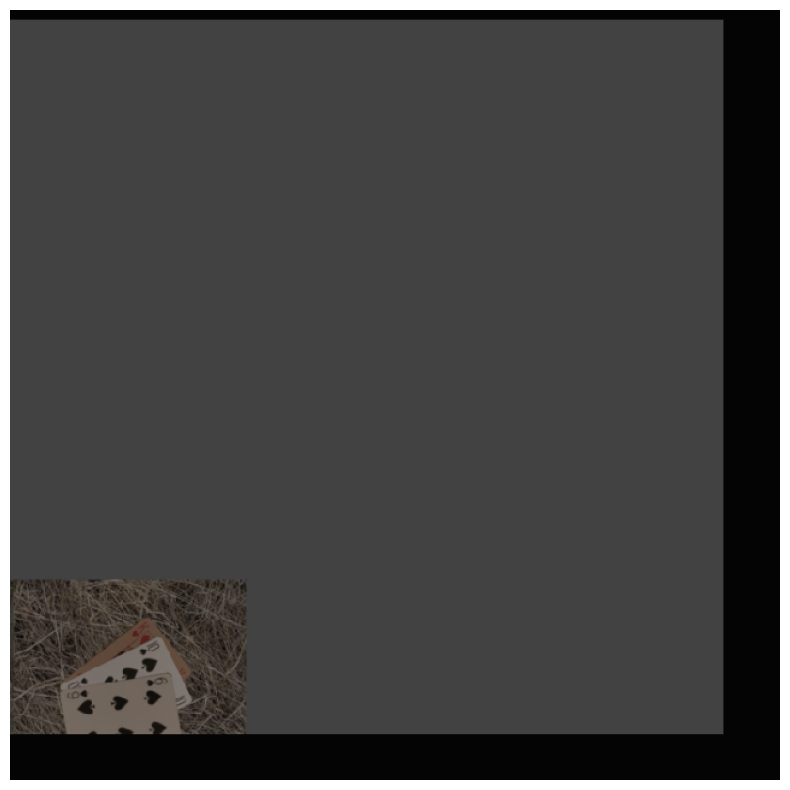


Sample 11550:
Targets shape: torch.Size([0, 5])
Targets content:
tensor([], size=(0, 5))
Visualizing sample with 0 targets


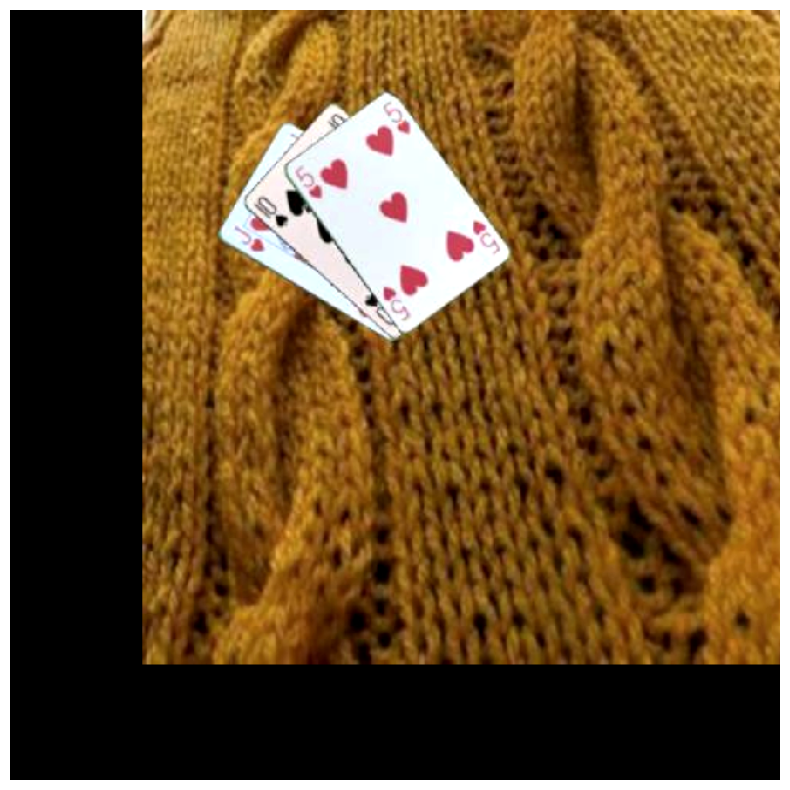


Sample 1707:
Targets shape: torch.Size([0, 5])
Targets content:
tensor([], size=(0, 5))
Visualizing sample with 0 targets


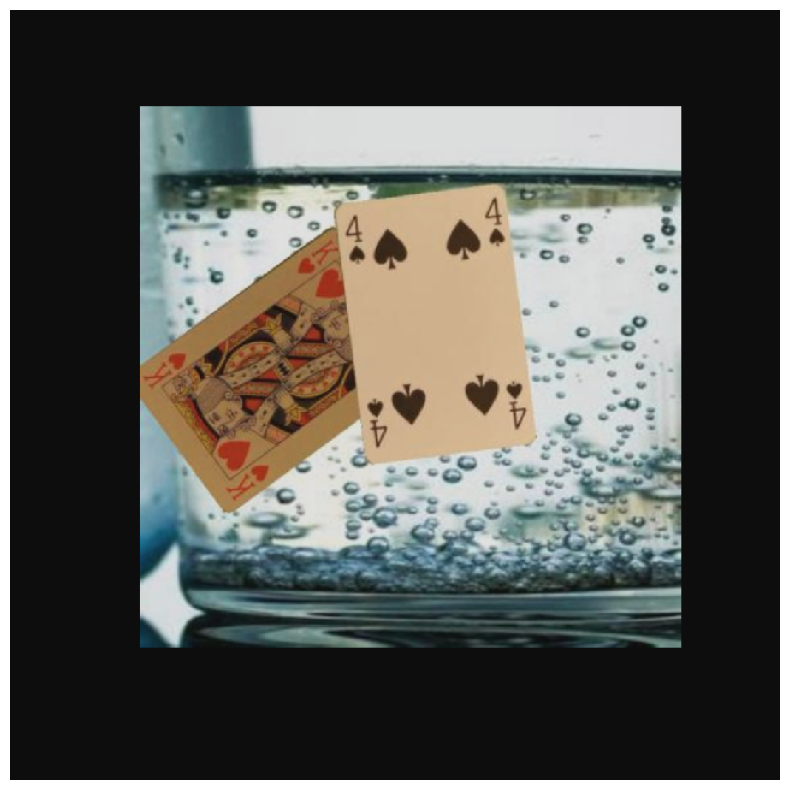


Sample 12464:
Targets shape: torch.Size([0, 5])
Targets content:
tensor([], size=(0, 5))
Visualizing sample with 0 targets


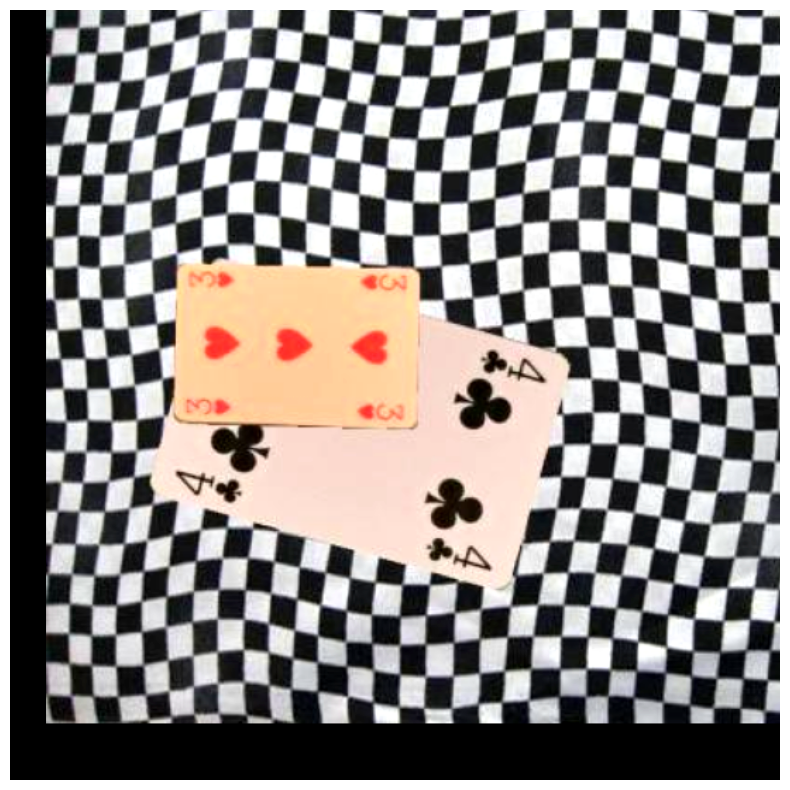


Sample 16103:
Targets shape: torch.Size([0, 5])
Targets content:
tensor([], size=(0, 5))
Visualizing sample with 0 targets


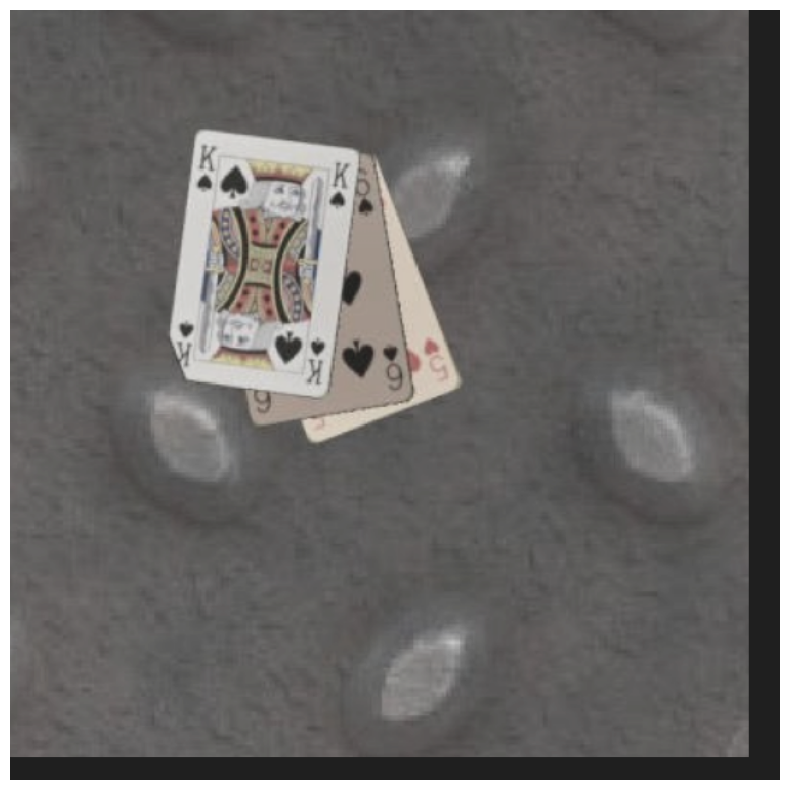

In [6]:
# --- Visualization Function ---
def visualize_sample(img_tensor, targets, class_names):
    # img_tensor: [3, H, W], float 0-1
    # targets: [N, 6] -> [idx, cls, x, y, w, h] normalized
    
    print(f"Visualizing sample with {len(targets)} targets")
    
    # Denormalize image
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8).copy()
    h, w = img.shape[:2]
    
    # Draw boxes
    for t in targets:
        cls_id = int(t[1])
        box = t[2:] # x, y, w, h normalized
        
        # Convert to xyxy absolute
        x1 = int((box[0] - box[2] / 2) * w)
        y1 = int((box[1] - box[3] / 2) * h)
        x2 = int((box[0] + box[2] / 2) * w)
        y2 = int((box[1] + box[3] / 2) * h)
        
        print(f"Box: {class_names[cls_id]} at [{x1}, {y1}, {x2}, {y2}]")
        
        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Draw label
        label = class_names[cls_id]
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# --- Display Examples ---
print("Displaying random augmented samples...")
indices = random.sample(range(len(dataset)), 5)

for i in indices:
    img, targets = dataset[i]
    # targets from dataset is [N, 5] -> [cls, x, y, w, h]
    
    print(f"\nSample {i}:")
    print(f"Targets shape: {targets.shape}")
    print(f"Targets content:\n{targets}")
    
    # Add dummy batch index
    targets_with_idx = torch.cat((torch.zeros((targets.shape[0], 1)), targets), dim=1)
    
    visualize_sample(img, targets_with_idx, class_names)